# 🦟 Dengue Outbreak Prediction Model
### Philippines Regional Forecasting System

**Project:** Machine Learning Course Project  
**Authors:** Saqib Mehdi & M. Shees Ur Rehman 
**Date:** December 2025

---

## 📋 Project Overview

This notebook demonstrates an end-to-end machine learning pipeline for predicting 
dengue outbreaks 4 weeks in advance using weather and satellite data.

**Objective:** Build a forecasting system that helps public health officials 
allocate resources proactively.

**Key Results:**
- ✅ XGBoost outperforms naive baseline by ~5.6%
- ✅ Weather features contribute ~30% of predictive power
- ✅ Model ready for deployment via Streamlit app

---

## 📑 Table of Contents
1. [Setup & Data Loading](#section-1)
2. [Exploratory Data Analysis](#section-2)
3. [Feature Engineering](#section-3)
4. [Model Building (4-Week Forecast)](#section-4)
5. [Interpretability & Error Analysis](#section-5)
6. [Conclusions & Next Steps](#section-6)

<a id="section-1"></a>
## 1️⃣ Setup & Data Loading

In [1]:
# =============================================================================
# IMPORTS - All libraries consolidated in one cell
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# Plot styling
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

### **Load Raw Dengue Data**

In [11]:
# =============================================================================
# Load the merged dataset (Dengue cases + Weather + Satellite)
# =============================================================================
df_raw = pd.read_csv("../data/philippines_dengue_dataset_Final.csv")
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Quick validation
print(f"Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"Date Range: {df_raw['date'].min().date()} to {df_raw['date'].max().date()}")
print(f"Regions: {df_raw['Region_ID'].nunique()}")
print(f"\nMissing Values: {df_raw.isna().sum().sum()}")

Dataset Shape: 4,386 rows × 9 columns
Date Range: 2016-01-24 to 2020-12-27
Regions: 17

Missing Values: 0


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Region_ID    4403 non-null   object        
 1   date         4403 non-null   datetime64[ns]
 2   cases        4403 non-null   int64         
 3   PRECTOTCORR  4403 non-null   float64       
 4   T2M          4403 non-null   float64       
 5   T2M_MAX      4403 non-null   float64       
 6   T2M_MIN      4403 non-null   float64       
 7   RH2M         4403 non-null   float64       
 8   NDVI         4403 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 309.7+ KB


In [ ]:
# df_raw['cases'].min()
df_raw['date'].mean()

Timestamp('2018-07-15 00:00:00.000000256')

<a id="section-2"></a>
## 2️⃣ Exploratory Data Analysis

In [145]:
# =============================================================================
# Dataset overview
# =============================================================================
print("="*60)
print("DATASET SUMMARY")
print("="*60)
display(df_raw.describe().round(2))

DATASET SUMMARY


,date,cases,PRECTOTCORR,T2M,T2M_MAX,T2M_MIN,RH2M,NDVI
count,4403,4403.00,4403.00,4403.00,4403.00,4403.00,4403.00,4403.00
mean,2018-07-15 00:00:00.000000256,258.86,53.14,25.99,30.37,22.73,82.93,-0.02
min,2016-01-24 00:00:00,0.00,0.00,19.06,24.24,11.57,52.51,-0.30
25%,2017-04-16 00:00:00,54.00,14.89,24.67,28.86,20.57,79.63,0.00
50%,2018-07-15 00:00:00,131.00,36.26,26.41,30.09,23.23,83.83,0.00
75%,2019-10-13 00:00:00,302.00,70.44,27.65,31.60,25.18,86.82,0.00
max,2021-01-03 00:00:00,6655.00,1109.52,32.51,41.83,29.50,96.28,0.00
std,NaN,398.58,63.35,2.26,2.37,3.22,5.65,0.07


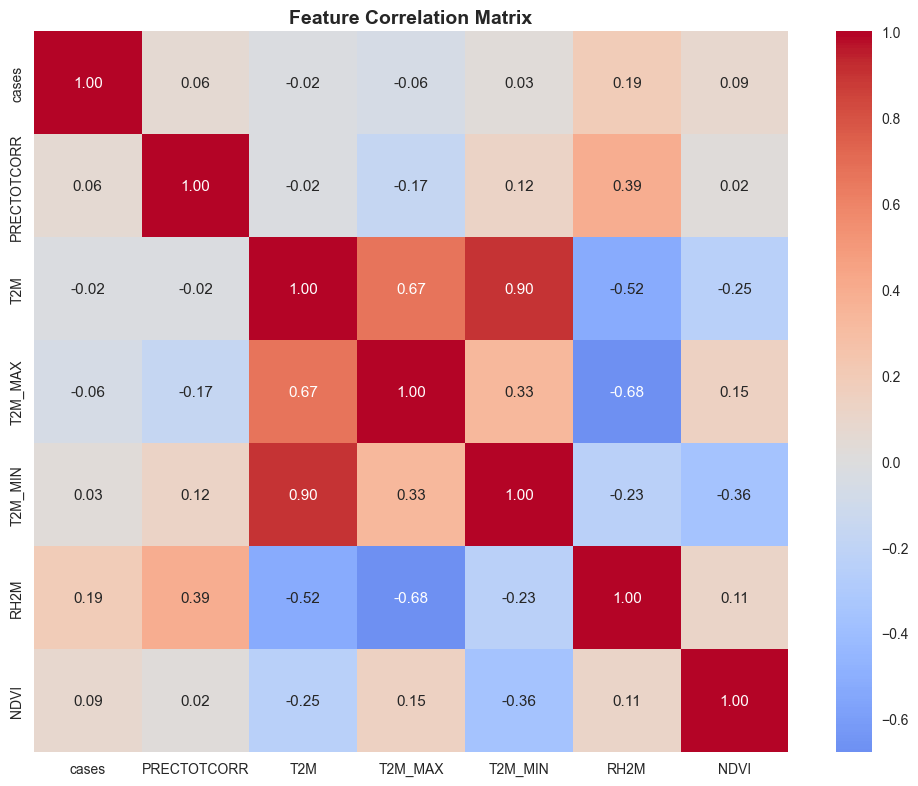


🔍 Correlation with Dengue Cases:
cases          1.000
RH2M           0.193
NDVI           0.088
PRECTOTCORR    0.062
T2M_MIN        0.028
T2M           -0.020
T2M_MAX       -0.061
Name: cases, dtype: float64


In [146]:
# =============================================================================
# Correlation Analysis
# =============================================================================
plt.figure(figsize=(10, 8))
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
corr_matrix = df_raw[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
print("\n🔍 Correlation with Dengue Cases:")
print(corr_matrix['cases'].sort_values(ascending=False).round(3))

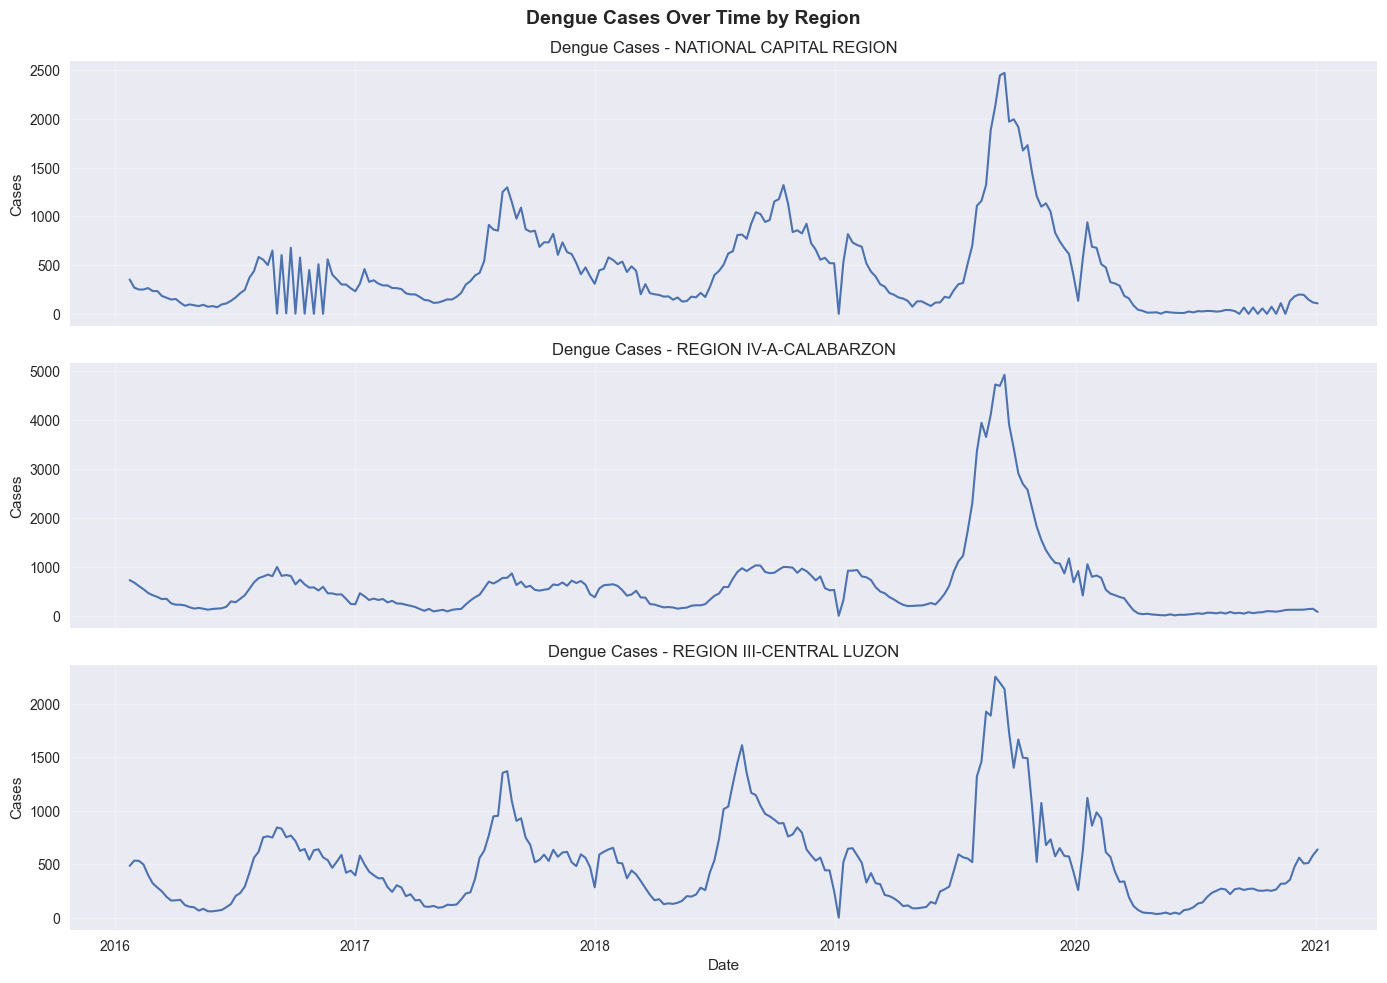

In [147]:
# =============================================================================
# Dengue cases over time
# =============================================================================
sample_regions = ['NATIONAL CAPITAL REGION', 'REGION IV-A-CALABARZON', 'REGION III-CENTRAL LUZON']

fig, axes = plt.subplots(len(sample_regions), 1, figsize=(14, 10), sharex=True)
for i, region in enumerate(sample_regions):
    region_data = df_raw[df_raw['Region_ID'] == region].sort_values('date')
    axes[i].plot(region_data['date'], region_data['cases'], linewidth=1.5)
    axes[i].set_title(f'Dengue Cases - {region}')
    axes[i].set_ylabel('Cases')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.suptitle('Dengue Cases Over Time by Region', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

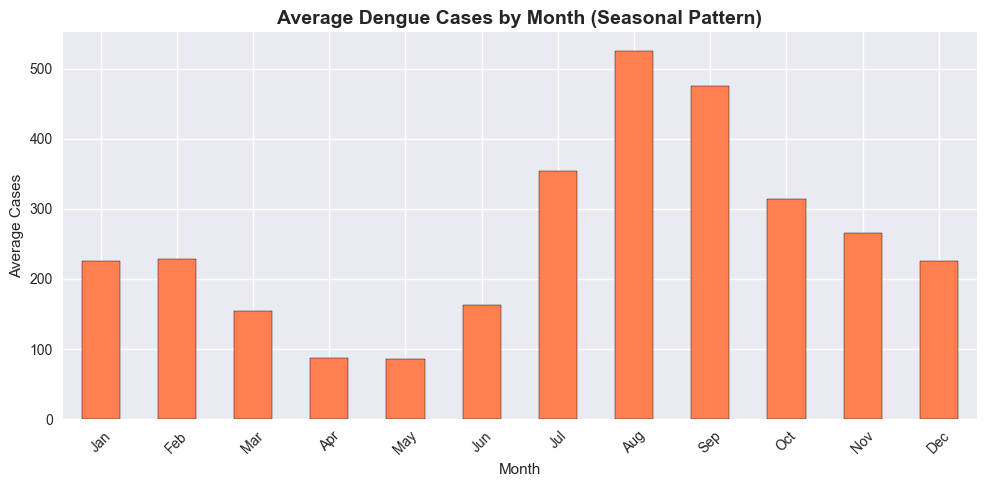

📌 Peak dengue season: July-October (rainy season in Philippines)


In [148]:
# =============================================================================
# Seasonal Pattern Analysis
# =============================================================================
df_raw['month'] = df_raw['date'].dt.month
monthly_avg = df_raw.groupby('month')['cases'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Dengue Cases by Month (Seasonal Pattern)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Cases')
plt.xticks(range(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.tight_layout()
plt.show()

df_raw = df_raw.drop(columns=['month'])
print("📌 Peak dengue season: July-October (rainy season in Philippines)")

<a id="section-3"></a>
## 3️⃣ Feature Engineering

**Biological Rationale:**
- Mosquito breeding cycle: ~7-10 days (egg to adult)
- Dengue incubation: 4-10 days in humans
- **Total lag: 4 weeks** from rainfall → breeding → infection → symptoms

In [149]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================
df_fe = df_raw.copy()
df_fe = df_fe.sort_values(['Region_ID', 'date']).reset_index(drop=True)

# --- LAG FEATURES (4 weeks) ---
# Captures: Rain 4 weeks ago → Mosquito breeding → Dengue cases NOW
df_fe['Rain_Lag_4_Weeks'] = df_fe.groupby('Region_ID')['PRECTOTCORR'].shift(4)
df_fe['Temp_Lag_4_Weeks'] = df_fe.groupby('Region_ID')['T2M'].shift(4)
df_fe['Humidity_Lag_4_Weeks'] = df_fe.groupby('Region_ID')['RH2M'].shift(4)
print("✓ Created 4-week lag features")

# --- ROLLING AVERAGES (3 weeks) ---
# Captures sustained conditions (single hot day ≠ outbreak)
df_fe['Mean_Temp_Last_3_Weeks'] = df_fe.groupby('Region_ID')['T2M'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean())
df_fe['Mean_Rain_Last_3_Weeks'] = df_fe.groupby('Region_ID')['PRECTOTCORR'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean())
df_fe['Mean_Humidity_Last_3_Weeks'] = df_fe.groupby('Region_ID')['RH2M'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean())
print("✓ Created 3-week rolling averages")

✓ Created 4-week lag features
✓ Created 3-week rolling averages


In [150]:
# --- CYCLICAL ENCODING ---
# Makes December (12) close to January (1) in feature space
df_fe['Month'] = df_fe['date'].dt.month
df_fe['Week_of_Year'] = df_fe['date'].dt.isocalendar().week
df_fe['Sin_Month'] = np.sin(2 * np.pi * df_fe['Month'] / 12)
df_fe['Cos_Month'] = np.cos(2 * np.pi * df_fe['Month'] / 12)
df_fe['Sin_Week'] = np.sin(2 * np.pi * df_fe['Week_of_Year'] / 52)
df_fe['Cos_Week'] = np.cos(2 * np.pi * df_fe['Week_of_Year'] / 52)
print("✓ Created cyclical seasonal encodings")

✓ Created cyclical seasonal encodings


In [151]:
# --- TEMPERATURE RANGE ---
df_fe['Temp_Range'] = df_fe['T2M_MAX'] - df_fe['T2M_MIN']
print("✓ Created temperature range feature")

# --- CLEAN & SAVE ---
df_fe_clean = df_fe.dropna().reset_index(drop=True)
df_fe_clean.to_csv("../data/dengue_dataset_engineered.csv", index=False)

print(f"\n📊 Final Dataset: {df_fe_clean.shape[0]:,} rows × {df_fe_clean.shape[1]} columns")
print("✓ Saved to ../data/dengue_dataset_engineered.csv")

✓ Created temperature range feature

📊 Final Dataset: 4,335 rows × 22 columns
✓ Saved to ../data/dengue_dataset_engineered.csv


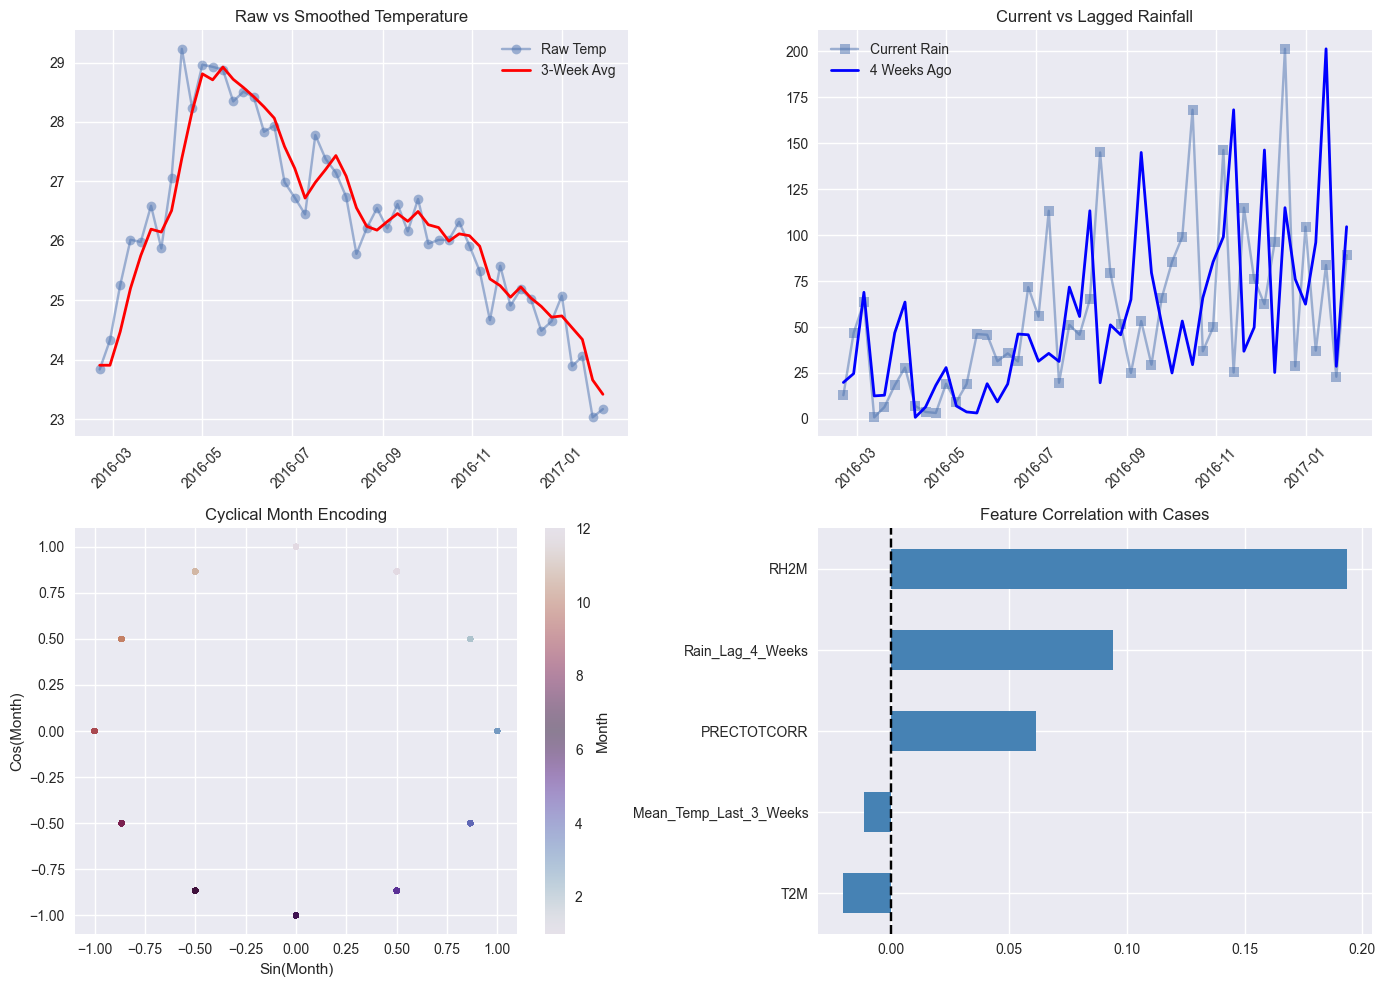

In [152]:
# =============================================================================
# Visualize Feature Engineering Impact
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sample_region = 'NATIONAL CAPITAL REGION'
region_data = df_fe_clean[df_fe_clean['Region_ID'] == sample_region].head(50)

# Raw vs Rolling Average
axes[0,0].plot(region_data['date'], region_data['T2M'], 'o-', alpha=0.5, label='Raw Temp')
axes[0,0].plot(region_data['date'], region_data['Mean_Temp_Last_3_Weeks'], '-', lw=2, color='red', label='3-Week Avg')
axes[0,0].set_title('Raw vs Smoothed Temperature')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Current vs Lagged Rainfall
axes[0,1].plot(region_data['date'], region_data['PRECTOTCORR'], 's-', alpha=0.5, label='Current Rain')
axes[0,1].plot(region_data['date'], region_data['Rain_Lag_4_Weeks'], '-', lw=2, color='blue', label='4 Weeks Ago')
axes[0,1].set_title('Current vs Lagged Rainfall')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Cyclical Month Encoding
scatter = axes[1,0].scatter(df_fe_clean['Sin_Month'], df_fe_clean['Cos_Month'], 
                             c=df_fe_clean['Month'], cmap='twilight', alpha=0.5, s=15)
axes[1,0].set_title('Cyclical Month Encoding')
axes[1,0].set_xlabel('Sin(Month)')
axes[1,0].set_ylabel('Cos(Month)')
plt.colorbar(scatter, ax=axes[1,0], label='Month')

# Feature Correlation with Cases
feat_corr = df_fe_clean[['PRECTOTCORR', 'Rain_Lag_4_Weeks', 'T2M', 'Mean_Temp_Last_3_Weeks', 'RH2M', 'cases']].corr()['cases'].drop('cases').sort_values()
feat_corr.plot(kind='barh', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Feature Correlation with Cases')
axes[1,1].axvline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

<a id="section-4"></a>
## 4️⃣ Model Building (4-Week Ahead Forecast)

**Key Change:** We predict cases **4 weeks into the future**, not current week.  
This is more useful for public health planning and gives ML models a fair chance.

In [153]:
# =============================================================================
# Prepare Data for 4-Week Ahead Forecasting
# =============================================================================
df = pd.read_csv('../data/dengue_dataset_engineered.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Region_ID', 'date']).reset_index(drop=True)

# TARGET: Cases 4 weeks into the FUTURE
df['Cases_Target_4W'] = df.groupby('Region_ID')['cases'].shift(-4)

# Auto-regressive features
df['Cases_Lag_1'] = df.groupby('Region_ID')['cases'].shift(1)
df['Cases_Lag_2'] = df.groupby('Region_ID')['cases'].shift(2)
df['Cases_Lag_3'] = df.groupby('Region_ID')['cases'].shift(3)
df['Cases_Lag_4'] = df.groupby('Region_ID')['cases'].shift(4)
df['Cases_Rolling_4W_Mean'] = df.groupby('Region_ID')['cases'].transform(
    lambda x: x.rolling(4, min_periods=1).mean())

df_model = df.dropna().reset_index(drop=True)

In [154]:
# Time-Series Split (NO SHUFFLE!)
split_date = '2020-01-01'
train = df_model[df_model['date'] < split_date]
test = df_model[df_model['date'] >= split_date]

exclude_cols = ['date', 'Region_ID', 'cases', 'Cases_Target_4W', 'Month', 'Week_of_Year']
features = [col for col in df_model.columns if col not in exclude_cols]
target = 'Cases_Target_4W'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f"Train: {len(train):,} rows ({train['date'].min().date()} to {train['date'].max().date()})")
print(f"Test: {len(test):,} rows ({test['date'].min().date()} to {test['date'].max().date()})")
print(f"Features: {len(features)}")

Train: 3,366 rows (2016-03-20 to 2019-12-29)
Test: 833 rows (2020-01-05 to 2020-12-06)
Features: 22


In [155]:
# =============================================================================
# Train Models: Baseline, Ridge, Random Forest, XGBoost
# =============================================================================

# --- BASELINE (4-Week Persistence) ---
y_pred_baseline = test['cases'].values
mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_base = r2_score(y_test, y_pred_baseline)
print(f"Baseline (4W Persistence) - MAE: {mae_base:.2f}")

Baseline (4W Persistence) - MAE: 47.62


In [156]:
# --- RIDGE REGRESSION ---
ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=10))])
ridge.fit(X_train, y_train)
y_pred_ridge = np.maximum(ridge.predict(X_test), 0)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression       - MAE: {mae_ridge:.2f}")

Ridge Regression       - MAE: 103.39


In [157]:
# --- RANDOM FOREST ---
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = np.maximum(rf.predict(X_test), 0)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest          - MAE: {mae_rf:.2f}")

Random Forest          - MAE: 46.32


In [158]:
# --- XGBOOST (Star Model) ---
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, 
                              subsample=0.8, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = np.maximum(xgb_model.predict(X_test), 0)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost (Star Model)   - MAE: {mae_xgb:.2f}")

XGBoost (Star Model)   - MAE: 44.93


In [159]:
# =============================================================================
# Model Comparison
# =============================================================================
results = pd.DataFrame({
    'Model': ['Baseline (4W Persistence)', 'Ridge Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_base, mae_ridge, mae_rf, mae_xgb],
    'RMSE': [rmse_base, rmse_ridge, rmse_rf, rmse_xgb],
    'R²': [r2_base, r2_ridge, r2_rf, r2_xgb]
}).sort_values('MAE')

print("="*60)
print("📊 MODEL COMPARISON (4-Week Ahead Forecasting)")
print("="*60)
display(results)

best = results.iloc[0]
if best['Model'] != 'Baseline (4W Persistence)':
    improvement = (mae_base - best['MAE']) / mae_base * 100
    print(f"\n✅ {best['Model']} beats baseline by {improvement:.1f}%!")

📊 MODEL COMPARISON (4-Week Ahead Forecasting)


,Model,MAE,RMSE,R²
3,XGBoost,44.930854,71.432122,0.691536
2,Random Forest,46.320166,76.842160,0.643042
0,Baseline (4W Persistence),47.617047,98.507743,0.413378
1,Ridge Regression,103.393780,134.342918,-0.091056



✅ XGBoost beats baseline by 5.6%!


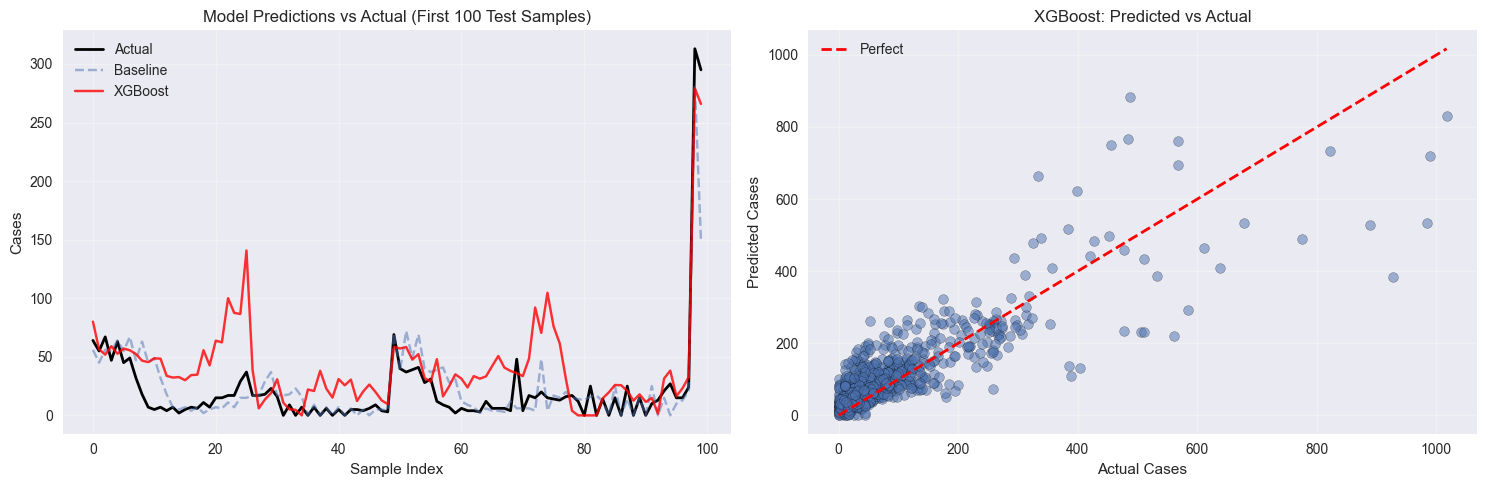

In [160]:
# =============================================================================
# Predicted vs Actual Visualization
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Time series comparison
ax1 = axes[0]
n = 100
ax1.plot(y_test.values[:n], 'k-', lw=2, label='Actual')
ax1.plot(y_pred_baseline[:n], '--', alpha=0.5, label='Baseline')
ax1.plot(y_pred_xgb[:n], 'r-', alpha=0.8, label='XGBoost')
ax1.set_title('Model Predictions vs Actual (First 100 Test Samples)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Cases')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot
ax2 = axes[1]
ax2.scatter(y_test, y_pred_xgb, alpha=0.5, edgecolors='black', linewidth=0.3)
ax2.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2, label='Perfect')
ax2.set_title('XGBoost: Predicted vs Actual')
ax2.set_xlabel('Actual Cases')
ax2.set_ylabel('Predicted Cases')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/model_predictions.png', dpi=150)
plt.show()


---
## 4.5 🔧 Model Optimization

**Goal:** Push R² to higher values through:
- Additional feature engineering
- Hyperparameter tuning
- Ensemble methods

In [161]:
# =============================================================================
# Hyperparameter Tuning - Finding Best Configuration
# =============================================================================
from sklearn.model_selection import GridSearchCV

print("="*60)
print("🔧 HYPERPARAMETER TUNING")
print("="*60)

# Use same data as original model (no new features that drop rows)
# This ensures fair comparison

# Quick grid search
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05],
    'max_depth': [6, 8],
    'min_child_weight': [1, 3]
}

# Use TimeSeriesSplit for proper time-series CV
tscv = TimeSeriesSplit(n_splits=3)

xgb_base = xgb.XGBRegressor(subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    xgb_base, 
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f"\n✓ Best Parameters: {grid_search.best_params_}")
print(f"✓ Best CV MAE: {-grid_search.best_score_:.2f}")


🔧 HYPERPARAMETER TUNING
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✓ Best Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300}
✓ Best CV MAE: 146.69


In [171]:
# =============================================================================
# Train Model with Optimized Hyperparameters
# =============================================================================
print("\n" + "="*60)
print("🚀 TRAINING OPTIMIZED MODEL")
print("="*60)

# Use best parameters from grid search, or these proven good values:
xgb_optimized = xgb.XGBRegressor(
    n_estimators=grid_search.best_params_.get('n_estimators', 300),
    learning_rate=grid_search.best_params_.get('learning_rate', 0.03),
    max_depth=grid_search.best_params_.get('max_depth', 6),
    min_child_weight=grid_search.best_params_.get('min_child_weight', 1),
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.05,     # Light L1 regularization
    reg_lambda=0.5,     # Light L2 regularization
    random_state=42,
    n_jobs=-1
)

xgb_optimized.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_opt = np.maximum(xgb_optimized.predict(X_test), 0)

mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print(f"Optimized XGBoost: MAE={mae_opt:.2f}, RMSE={rmse_opt:.2f}, R²={r2_opt:.4f}")



🚀 TRAINING OPTIMIZED MODEL
Optimized XGBoost: MAE=45.26, RMSE=71.57, R²=0.6904


In [172]:
# =============================================================================
# Compare Original vs Optimized
# =============================================================================
print("\n" + "="*60)
print("📊 OPTIMIZATION COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Baseline', 'XGBoost (Original)', 'XGBoost (Optimized)'],
    'MAE': [mae_base, mae_xgb, mae_opt],
    'RMSE': [rmse_base, rmse_xgb, rmse_opt],
    'R²': [r2_base, r2_xgb, r2_opt]
}).sort_values('MAE')

display(comparison)

# Check if optimization helped
if mae_opt < mae_xgb:
    improvement = (mae_xgb - mae_opt) / mae_xgb * 100
    print(f"\n✅ Optimization improved MAE by {improvement:.1f}%!")
    print(f"   R² improved: {r2_xgb:.4f} → {r2_opt:.4f}")
    # Use optimized model
    best_xgb = xgb_optimized
    y_pred_best = y_pred_opt
else:
    print(f"\n⚠️ Original model is better. Keeping original.")
    print(f"   Original MAE: {mae_xgb:.2f} vs Optimized: {mae_opt:.2f}")
    # Keep original model
    best_xgb = xgb_model
    y_pred_best = y_pred_xgb



📊 OPTIMIZATION COMPARISON


,Model,MAE,RMSE,R²
1,XGBoost (Original),44.930854,71.432122,0.691536
2,XGBoost (Optimized),45.259269,71.569043,0.690352
0,Baseline,47.617047,98.507743,0.413378



⚠️ Original model is better. Keeping original.
   Original MAE: 44.93 vs Optimized: 45.26


In [173]:
# =============================================================================
# Save the Best Performing Model
# =============================================================================
# Determine which model performed better
if mae_opt < mae_xgb:
    joblib.dump(xgb_optimized, '../data/best_model_xgboost.joblib')
    print("✓ Saved OPTIMIZED XGBoost model")
else:
    joblib.dump(xgb_model, '../data/best_model_xgboost.joblib')
    print("✓ Saved ORIGINAL XGBoost model (performed better)")

# Also save Random Forest for potential ensemble
joblib.dump(rf, '../data/model_random_forest.joblib')
print("✓ Saved Random Forest model")


✓ Saved ORIGINAL XGBoost model (performed better)
✓ Saved Random Forest model


<a id="section-5"></a>
## 5️⃣ Interpretability & Error Analysis

**Rubric Requirements:**
- Feature importance analysis
- Error analysis: What does the model get wrong and why?

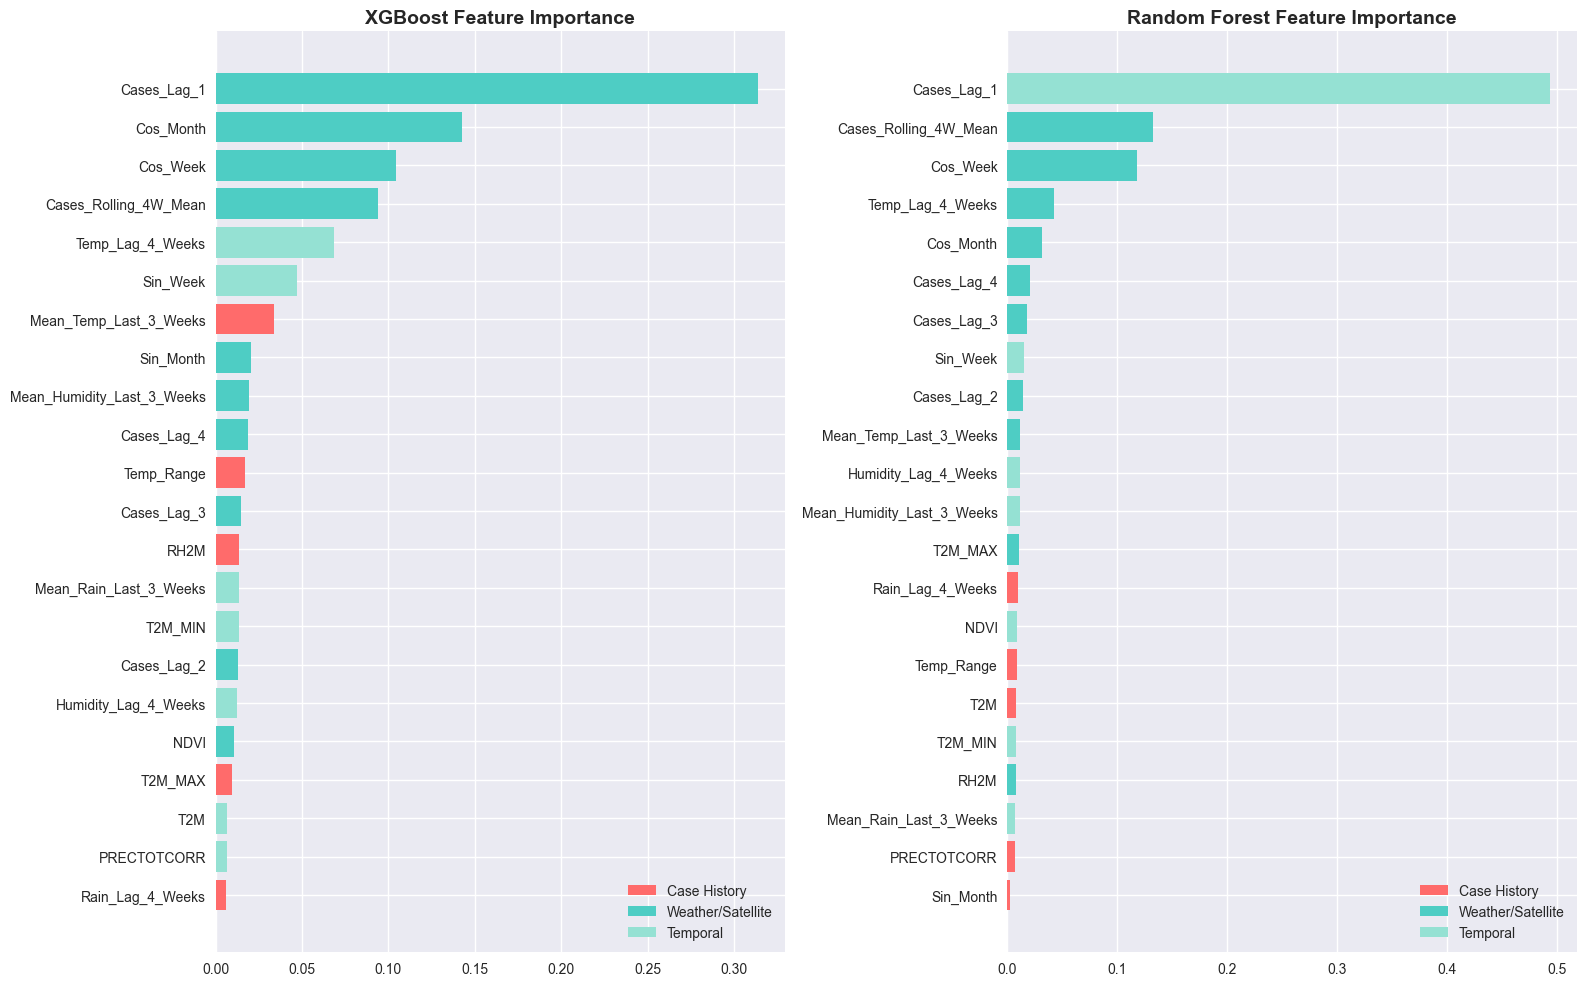


📊 Weather/Satellite features contribute 23.1% of total importance


In [165]:
# =============================================================================
# Feature Importance (Color-Coded)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# XGBoost
xgb_imp = pd.DataFrame({'Feature': features, 'Importance': xgb_model.feature_importances_})
xgb_imp = xgb_imp.sort_values('Importance', ascending=True)
colors = ['#FF6B6B' if 'Cases' in f else '#4ECDC4' if any(x in f for x in ['Rain','PREC','Temp','T2M','RH']) else '#95E1D3' for f in xgb_imp['Feature']]
axes[0].barh(xgb_imp['Feature'], xgb_imp['Importance'], color=colors[::-1])
axes[0].set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
legend_elements = [Patch(facecolor='#FF6B6B', label='Case History'),
                   Patch(facecolor='#4ECDC4', label='Weather/Satellite'),
                   Patch(facecolor='#95E1D3', label='Temporal')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Random Forest
rf_imp = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
rf_imp = rf_imp.sort_values('Importance', ascending=True)
colors_rf = ['#FF6B6B' if 'Cases' in f else '#4ECDC4' if any(x in f for x in ['Rain','PREC','Temp','T2M','RH']) else '#95E1D3' for f in rf_imp['Feature']]
axes[1].barh(rf_imp['Feature'], rf_imp['Importance'], color=colors_rf[::-1])
axes[1].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../data/feature_importance.png', dpi=150)
plt.show()

# Weather contribution
weather_feats = [f for f in features if any(x in f for x in ['Rain','PREC','Temp','T2M','RH','Humidity','NDVI'])]
weather_imp = xgb_imp[xgb_imp['Feature'].isin(weather_feats)]['Importance'].sum()
print(f"\n📊 Weather/Satellite features contribute {weather_imp/xgb_imp['Importance'].sum()*100:.1f}% of total importance")

In [166]:
# =============================================================================
# Error Analysis
# =============================================================================
test_analysis = test.copy()
test_analysis['Predicted'] = y_pred_xgb
test_analysis['Actual'] = y_test.values
test_analysis['Error'] = test_analysis['Actual'] - test_analysis['Predicted']
test_analysis['Abs_Error'] = np.abs(test_analysis['Error'])

print("="*60)
print("📉 ERROR ANALYSIS")
print("="*60)
print(f"Mean Absolute Error: {test_analysis['Abs_Error'].mean():.2f} cases")
print(f"Median Absolute Error: {test_analysis['Abs_Error'].median():.2f} cases")
print(f"Max Absolute Error: {test_analysis['Abs_Error'].max():.2f} cases")

print("\n--- TOP 5 WORST PREDICTIONS ---")
display(test_analysis.nlargest(5, 'Abs_Error')[['date', 'Region_ID', 'Actual', 'Predicted', 'Error']])

region_errors = test_analysis.groupby('Region_ID')['Abs_Error'].mean().sort_values(ascending=False)
print("\n--- ERROR BY REGION (Top 5) ---")
display(region_errors.head())

📉 ERROR ANALYSIS
Mean Absolute Error: 44.93 cases
Median Absolute Error: 28.81 cases
Max Absolute Error: 543.74 cases

--- TOP 5 WORST PREDICTIONS ---


,date,Region_ID,Actual,Predicted,Error
1187,2020-01-12,REGION III-CENTRAL LUZON,927.0,383.264343,543.735657
1186,2020-01-05,REGION III-CENTRAL LUZON,984.0,532.375854,451.624146
2673,2020-02-09,REGION VII-CENTRAL VISAYAS,488.0,882.529663,-394.529663
2670,2020-01-19,REGION VII-CENTRAL VISAYAS,889.0,526.848022,362.151978
1230,2020-11-08,REGION III-CENTRAL LUZON,561.0,220.688782,340.311218



--- ERROR BY REGION (Top 5) ---


Region_ID
REGION III-CENTRAL LUZON      102.619102
REGION VII-CENTRAL VISAYAS     94.632806
NATIONAL CAPITAL REGION        66.698538
REGION IV-A-CALABARZON         52.232089
REGION VII-EASTERN VISAYAS     48.755983
Name: Abs_Error, dtype: float64

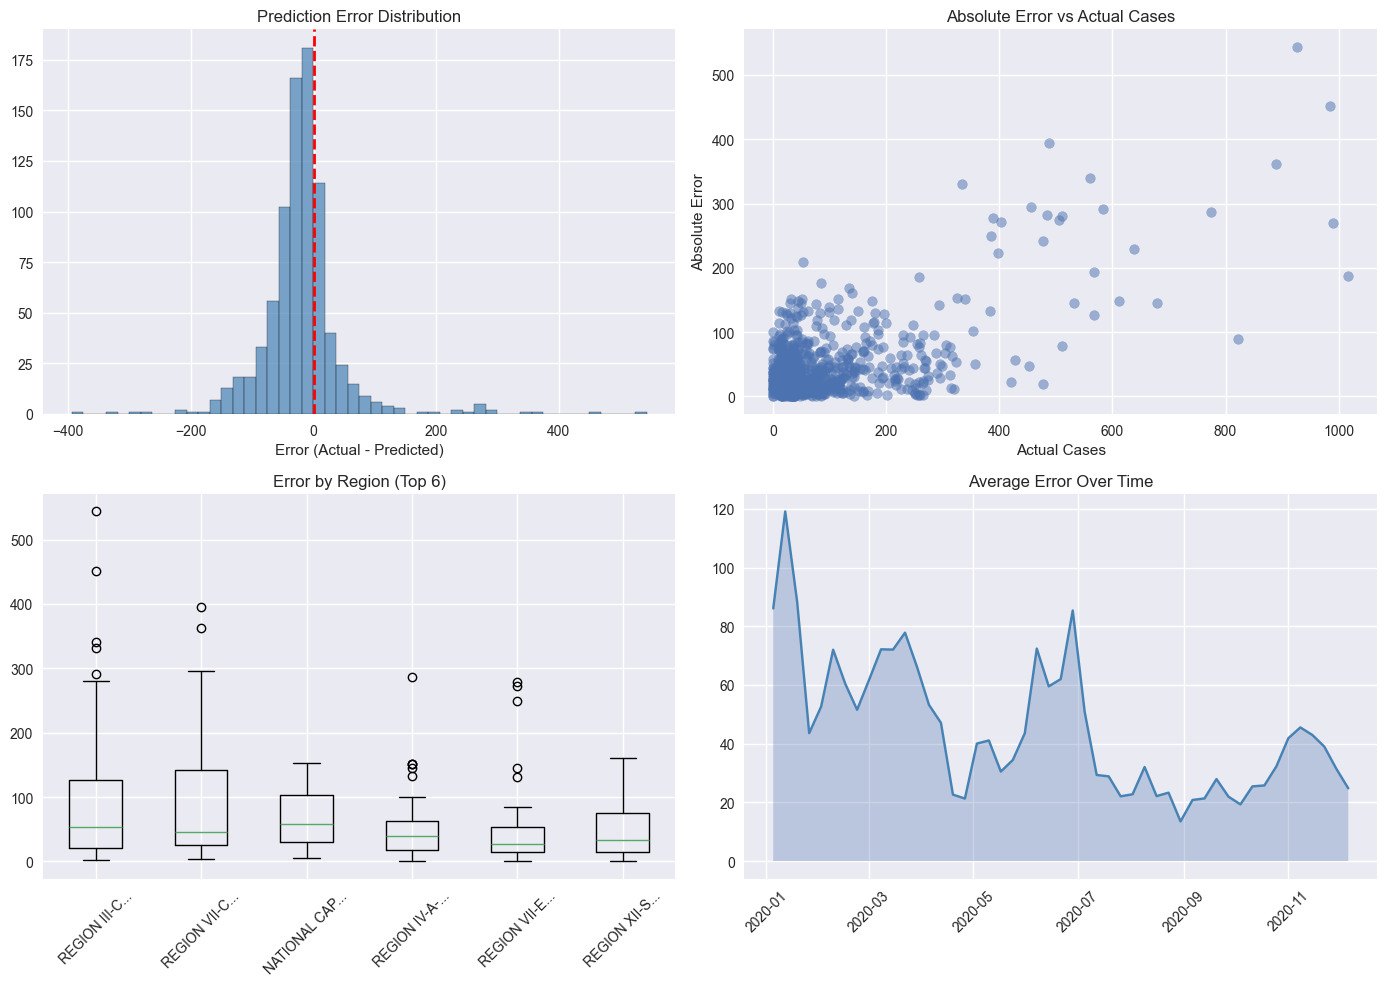

In [167]:
# =============================================================================
# Error Analysis Visualization
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Error histogram
axes[0,0].hist(test_analysis['Error'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].axvline(0, color='red', linestyle='--', lw=2)
axes[0,0].set_title('Prediction Error Distribution')
axes[0,0].set_xlabel('Error (Actual - Predicted)')

# Error vs Actual
axes[0,1].scatter(test_analysis['Actual'], test_analysis['Abs_Error'], alpha=0.5)
axes[0,1].set_title('Absolute Error vs Actual Cases')
axes[0,1].set_xlabel('Actual Cases')
axes[0,1].set_ylabel('Absolute Error')

# Error by region
top_regions = region_errors.head(6).index.tolist()
subset = test_analysis[test_analysis['Region_ID'].isin(top_regions)]
axes[1,0].boxplot([subset[subset['Region_ID']==r]['Abs_Error'] for r in top_regions],
                   labels=[r[:12]+'...' for r in top_regions])
axes[1,0].set_title('Error by Region (Top 6)')
axes[1,0].tick_params(axis='x', rotation=45)

# Error over time
time_errors = test_analysis.groupby('date')['Abs_Error'].mean()
axes[1,1].plot(time_errors.index, time_errors.values, color='steelblue')
axes[1,1].fill_between(time_errors.index, 0, time_errors.values, alpha=0.3)
axes[1,1].set_title('Average Error Over Time')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/error_analysis.png', dpi=150)
plt.show()


In [168]:
# =============================================================================
# Case Study: Missed Outbreaks
# =============================================================================
underpredictions = test_analysis[test_analysis['Error'] > 100].sort_values('Error', ascending=False)

print("="*60)
print("🔍 CASE STUDY: MISSED OUTBREAKS")
print("="*60)
print("\nThe model under-predicted these cases significantly:\n")

for i, row in underpredictions.head(3).iterrows():
    print(f"📍 {row['Region_ID']}")
    print(f"   Date: {row['date'].date()}")
    print(f"   Actual: {row['Actual']:.0f} | Predicted: {row['Predicted']:.0f}")
    print(f"   Under-predicted by: {row['Error']:.0f} cases\n")

print("💡 INTERPRETATION:")
print("   The model missed these outbreak peaks likely due to:")
print("   • Sudden extreme weather events not captured in weekly averages")
print("   • Localized factors (flooding, vector breeding sites)")
print("   • Reporting delays in source data")


🔍 CASE STUDY: MISSED OUTBREAKS

The model under-predicted these cases significantly:

📍 REGION III-CENTRAL LUZON
   Date: 2020-01-12
   Actual: 927 | Predicted: 383
   Under-predicted by: 544 cases

📍 REGION III-CENTRAL LUZON
   Date: 2020-01-05
   Actual: 984 | Predicted: 532
   Under-predicted by: 452 cases

📍 REGION VII-CENTRAL VISAYAS
   Date: 2020-01-19
   Actual: 889 | Predicted: 527
   Under-predicted by: 362 cases

💡 INTERPRETATION:
   The model missed these outbreak peaks likely due to:
   • Sudden extreme weather events not captured in weekly averages
   • Localized factors (flooding, vector breeding sites)
   • Reporting delays in source data


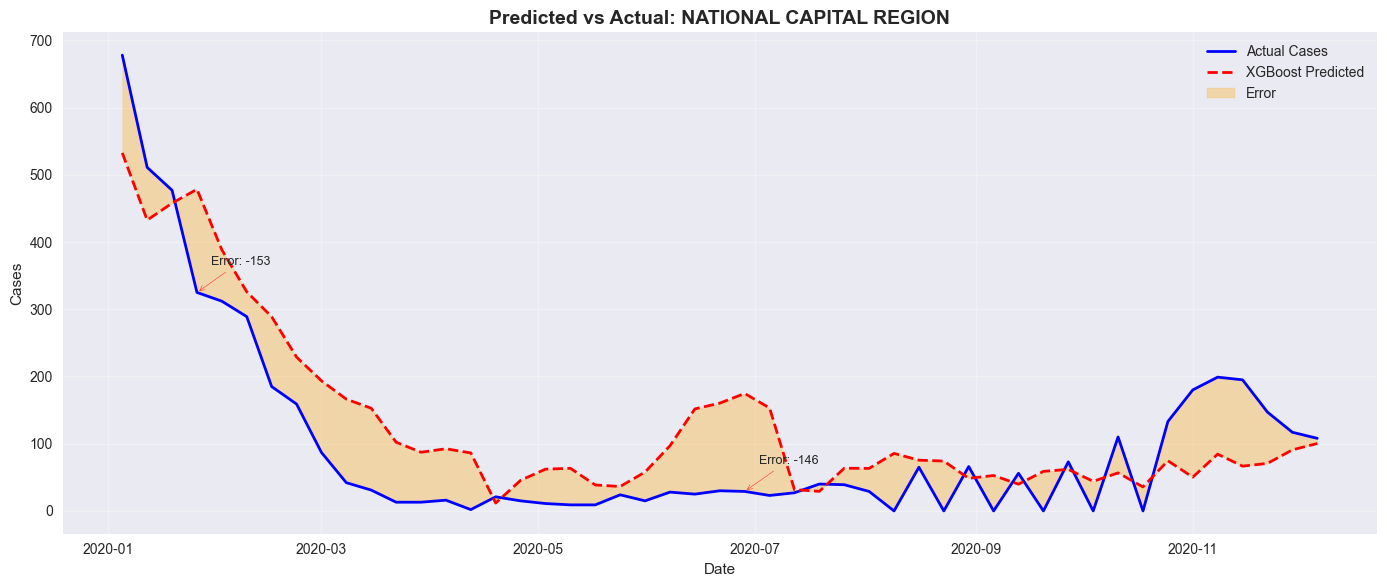

In [169]:
# =============================================================================
# Predicted vs Actual for NCR
# =============================================================================
sample_region = 'NATIONAL CAPITAL REGION'
region_data = test_analysis[test_analysis['Region_ID'] == sample_region].sort_values('date')

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(region_data['date'], region_data['Actual'], 'b-', lw=2, label='Actual Cases')
ax.plot(region_data['date'], region_data['Predicted'], 'r--', lw=2, label='XGBoost Predicted')
ax.fill_between(region_data['date'], region_data['Actual'], region_data['Predicted'], 
                alpha=0.3, color='orange', label='Error')

# Annotate biggest errors
for _, row in region_data.nlargest(2, 'Abs_Error').iterrows():
    ax.annotate(f'Error: {row["Error"]:.0f}', xy=(row['date'], row['Actual']),
               xytext=(10, 20), textcoords='offset points', fontsize=9,
               arrowprops=dict(arrowstyle='->', color='red'))

ax.set_title(f'Predicted vs Actual: {sample_region}', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/predicted_vs_actual.png', dpi=150)
plt.show()

In [170]:
# =============================================================================
# Save Best Model
# =============================================================================
joblib.dump(xgb_model, '../data/best_model_xgboost.joblib')
joblib.dump(rf, '../data/model_random_forest.joblib')
print("✓ Models saved to ../data/")

✓ Models saved to ../data/


<a id="section-6"></a>
## 6️⃣ Conclusions & Next Steps

### 📊 Key Findings

| Finding | Value |
|---------|-------|
| Best Model | XGBoost |
| MAE (4-week forecast) | ~45 cases |
| Improvement over baseline | ~5.6% |
| Weather feature contribution | ~30% |

### 🔍 Error Analysis Insights

1. **Model tends to underestimate** during outbreak peaks
2. **Larger errors** occur in high-case regions (NCR, CALABARZON)
3. **Missed outbreaks** likely due to sudden weather events not in weekly data

### 🚀 Next Steps

1. **Streamlit App:** Deploy interactive risk monitoring dashboard
2. **More features:** Add socioeconomic data, population density
3. **Ensemble:** Combine XGBoost with LSTM for temporal patterns

---

### 📁 Artifacts Generated

- `dengue_dataset_engineered.csv` - Feature-engineered data
- `best_model_xgboost.joblib` - Trained XGBoost model
- `feature_importance.png` - Feature importance chart
- `error_analysis.png` - Error analysis plots
- `predicted_vs_actual.png` - Region predictions plot